in this notebook im attempting to build an nlp model capable of predicted the missing tokens in a piece of text written IN THE TUNISIAN DARIJA , both with latin and arabic alphabet , ofcourse the model we be later on be used as a base model for other tasks (word infilling/generation , classification, question answering, named entity recognition, translation, sentiment analysis etc...)
for learning purposes im going to try to write every function from scratch


importing the necessary libraries (there will be more later on)


In [8]:
from datasets import load_dataset
import random
import tqdm
import json


c:\disque d\ai_stuff\projects\pytorchtraining\pytorch_training\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## downloading and exploring the dataset


In [21]:

ds = load_dataset("khaled123/Tunisian_Dialectic_English_Derja" , cache_dir= "darija_datasets")

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1664765
    })
})

In [28]:
train_data = ds["train"]


In [5]:
type(train_data)

datasets.arrow_dataset.Dataset

In [248]:
number_of_exemples= 2
for i in range(number_of_exemples):
    random_index = random.randint(0, len(train_data))
    print(f"Example {i+1}: {train_data[random_index]} ")

Example 1: {'text': 'منجية تراها تلحق بها لتسألها عن ابنتها مشهد نوفمبر آخر الليل داخلي المستشفى قاعة التمريض منجية ممرضة ممرضة يوجد بالقاعة'} 
Example 2: {'text': 'إي أكهو خليها'} 


## cleaning the dataset


In [114]:
#removing everythin other than alphanumeric characters

import re

def clean_text(text):
    text["text"] = re.sub(r'[^\u0600-\u06FFa-zA-Z0-9\s]', '', text["text"])
    text["text"] = text["text"].lower()
    text["text"] = ' '.join(text["text"].split())

    return text

cleaned_data = train_data.map(clean_text)
cleaned_data = cleaned_data.filter(lambda x: x["text"].strip() != '')

In [29]:
random.seed(42)
number_of_exemples= 5
for i in range(number_of_exemples):
    random_index = random.randint(0, len(cleaned_data))
    print(f"cleaned {i+1}: {cleaned_data[random_index]} ")
    print("----------------------------------------------------")


cleaned 1: {'text': 'question اكتب تغريدة إيجابية answer الخطوة 1 حدد موضوع عام إيجابي باش نختار الامتنان كموضوع إيجابي للتغريدة خاطر يشجع الناس على تقدير الحاجات المليحة في حياتهم وينشر السعادة الخطوة 2 اختر تركيز محدد مهم إنو التغريدة تكون قريبة للناس، لذلك باش نركز على الأفراح اليومية والإنجازات اللي ينجموا الناس يتعاطفوا معاها ويعترفوا بيها الخطوة 3 بناء التغريدة باش نستعمل لغة غير رسمية ونخلي التغريدة قصيرة، خاطر التغريدات عندها حد أقصى من الحروف 280 إضافة الرموز التعبيرية تنجم تعزز الرسالة الإيجابية الخطوة 4 مراجعة وإنهاء التغريدة بعد المراجعة، نتأكد إنو التغريدة تثير شعور إيجابي وعندها القدرة على التفاعل مع جمهور واسع التغريدة النهائية اليوم، خلينا نحتفل بالنصر الصغير ونعتز بلحظات الفرح تذكروا إنكم تكونوا ممتنين للحاجات الصغيرة اللي تخلي الحياة جميلة امتنان إيجابية'} 
----------------------------------------------------
cleaned 2: {'text': 'sure lets break down the translation stepbystep step 1 translation the original tunisian dialect text is الفليجة اللي خذاتها ما عجبتنيش مشيت

# Tokenization


lets try tokenizing the dataset !


ofcourse there is multiple  of tokenization algorithms , like BPE , word tokenization ,  WordPiece , and sentence tokenization ect .

for the first try im going to go with word tokenizaiton


In [8]:
vocab_dict={}
repetition_dict={}

def tokenize_Data_by_word (text):    
    phrase = text["text"].lower().split()
    result = []
    for word in phrase:
        if word in vocab_dict:
            result.append(vocab_dict[word])
            repetition_dict[word]+=1
        else:
            vocab_dict[word] = len(vocab_dict)
            result.append(vocab_dict[word])
            repetition_dict[word]=0
    return {"text" :result}

tokenized_data = cleaned_data.map(tokenize_Data_by_word)


In [6]:
len(vocab_dict) 
len(repetition_dict)

0

In [7]:
for index , (key, value )in enumerate(vocab_dict.items()):
    print(f"key : {key} , value : {value} , rep : {repetition_dict[key]}")
    if index >10 :
        break

we can clearly see with this method the vocab dictionary gets wayy wayyy too bigg due to our method and to our data having both arabic and english and also multiple prounonciations and type of writting for the same words, not efficient for our purposes and also does not handle the case where unkown words are entered , huge issue
lets try implementing another methode , specifically

## bite pair encoding (bpe)


first step lets create our initial vocab dictionary , it will contain the basic caracteres and numbers 

In [9]:
vocab_dict = {}

english_letters = [chr(i) for i in range(ord('a'), ord('z') + 1)]

arabic_letters = [
    'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ',
    'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص',
    'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق',
    'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي'
]
digits = [str(i) for i in range(10)]

all_chars = english_letters + arabic_letters + digits

for idx, char in enumerate(all_chars):
    vocab_dict[char] = idx
vocab_dict[" "] = 64
vocab_dict["[UNK]"] =65
vocab_dict["[CLS]"] =66
vocab_dict["[SEP]"] =67
vocab_dict["[MASK]"] =68
vocab_dict["[PAD]"] =69

print(vocab_dict)


{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'ا': 26, 'ب': 27, 'ت': 28, 'ث': 29, 'ج': 30, 'ح': 31, 'خ': 32, 'د': 33, 'ذ': 34, 'ر': 35, 'ز': 36, 'س': 37, 'ش': 38, 'ص': 39, 'ض': 40, 'ط': 41, 'ظ': 42, 'ع': 43, 'غ': 44, 'ف': 45, 'ق': 46, 'ك': 47, 'ل': 48, 'م': 49, 'ن': 50, 'ه': 51, 'و': 52, 'ي': 53, '0': 54, '1': 55, '2': 56, '3': 57, '4': 58, '5': 59, '6': 60, '7': 61, '8': 62, '9': 63, ' ': 64, '[UNK]': 65, '[CLS]': 66, '[SEP]': 67, '[MASK]': 68, '[PAD]': 69}


In [9]:
len(vocab_dict) 

70

ofcourse that not our vocab dictionary but its base for now , we need build our vocab based on our training data , we will specify the size to be 20000 (it will stop around that number but not specificly at that number)


In [10]:
max_vocab_size = 20000
def tokenize(text , vocab_dict=vocab_dict , ignore_unknown=False):
    text = text.lower()
    tokens =[]
    encoding =[]
    i=0
    MAX_SUBWORD_LEN = 8

    while(i<len(text)):
        found = False
        for j in range(min(i + MAX_SUBWORD_LEN, len(text)), i, -1):
            subword = text[i:j]
            if subword in vocab_dict:
                tokens.append(subword)
                encoding.append(vocab_dict[subword])
                found = True
                i=j
                break
        if not found :
            i+=1
            if  ignore_unknown==False:
                tokens.append("[UNK]")
                encoding.append(vocab_dict["[UNK]"])
    return tokens , encoding
            

            


In [8]:
phrase1 = "chappaty is really tastyy"
phrase2 = "صباح الخير"
print(tokenize( phrase1))
print(tokenize(phrase2))
print(tokenize("[CLS]    "+phrase2))


(['c', 'h', 'a', 'p', 'p', 'a', 't', 'y', ' ', 'i', 's', ' ', 'r', 'e', 'a', 'l', 'l', 'y', ' ', 't', 'a', 's', 't', 'y', 'y'], [2, 7, 0, 15, 15, 0, 19, 24, 64, 8, 18, 64, 17, 4, 0, 11, 11, 24, 64, 19, 0, 18, 19, 24, 24])
(['ص', 'ب', 'ا', 'ح', ' ', 'ا', 'ل', 'خ', 'ي', 'ر'], [39, 27, 26, 31, 64, 26, 48, 32, 53, 35])
(['[UNK]', 'c', 'l', 's', '[UNK]', ' ', ' ', ' ', ' ', 'ص', 'ب', 'ا', 'ح', ' ', 'ا', 'ل', 'خ', 'ي', 'ر'], [65, 2, 11, 18, 65, 64, 64, 64, 64, 39, 27, 26, 31, 64, 26, 48, 32, 53, 35])


the below algorithm works as the following , first we get a big chunck of continous text , tokenize it with our current vocab dictionary , find the top 500 frequent token pair that are over the specified minimum frequency , add them to the vocab dictionary , and repeat , untill we have over 20000 tokens in the vocab dict

In [37]:
#lets take top 500 repeting tokens
num_token_to_take = 500
min_frequency= 500
max_vocab_size = 20000

def add_to_vocab(chunk):
    phrase = chunk.lower()
    tokens , encoding = tokenize(phrase)
    #print("generated tokens")
    #coupeling
    temp= {}
    for i in (range(0,len(tokens))):
        if i+1 > len(tokens)-1 :
            break
        if tokens[i] == "[UNK]" or tokens[i+1] == "[UNK]" or len(tokens[i+1])+len(tokens[i])>8:
            continue

        pair = tokens[i]+tokens[i+1]
        if pair in temp:
            temp[pair]+=1
        else:
            temp[pair]=1
    sorted_new_tokens = sorted(temp.items(), key=lambda x: x[1], reverse=True)
    #lets take top 500 repeting tokens
    added=0
    for  new_token , freq in  sorted_new_tokens:
        if freq<min_frequency:
            break
        if new_token not in vocab_dict:
            vocab_dict[new_token] = len(vocab_dict)
            added+=1
        if added>=num_token_to_take:
            break
 
#TO PASS the data as big chunks of text
def get_chunk(data, chunk_size=150_000_000):
    current_chunk = []
    current_len = 0

    for example in data:
        text = example["text"] + " "
        current_chunk.append(text)
        current_len += len(text)

        if current_len >= chunk_size:
            yield "".join(current_chunk)
            current_chunk = []
            current_len = 0

    if current_chunk:
        yield "".join(current_chunk)



        






In [38]:
gen = get_chunk(cleaned_data)
print(f"returned : {len(next(gen))}")

returned : 150001400


BUILDING THE VOCAB


In [ ]:

max_iter = 100
iter = 0
while (len(vocab_dict) < max_vocab_size):
    if iter>=max_iter:
        break
    for i in tqdm.tqdm(get_chunk(cleaned_data)):
            
        iter += 1

        print(f"len of chunk : {len(i)}")
        old_vocab_size = len(vocab_dict)
        add_to_vocab(i)
        print(f" number of added tokens : {len(vocab_dict)-old_vocab_size} ,new vocab size : {len(vocab_dict)}")
        if len(vocab_dict) >= max_vocab_size:
            break

    print("full circle")




Lets see some exemple tokens!


In [ ]:
import random

sample = random.sample(list(vocab_dict.items()), 20)

for token, idx in sample:
    print(f"{repr(token):<10} -> {idx}")


## saving our vocabulary dict for future use


we will need to save and retrive our vocab dict later on so lets build a save and load functions


In [11]:
def save_vocab_dict(path , vocab_dict):
    with open(path, 'w' , encoding="utf-8") as f:
        json.dump(vocab_dict,f ,ensure_ascii=False)
def load_vocab_dict(path ):
    with open(path , "r" , encoding="utf-8") as f:
        vocab = json.load(f)
    return vocab


In [ ]:
path  = "./vocab_dict.json"
save_vocab_dict(path, vocab_dict)


In [12]:
path  = "./vocab_dict.json"

new_vocab = load_vocab_dict(path)

print(f"new vocab size : {len(new_vocab)}")

new vocab size : 20153


small test

In [11]:
import random

sample = random.sample(list(new_vocab.items()), 20)

for token, idx in sample:
    print(f"{repr(token):<10} -> {idx}")

'pment'    -> 13223
' موجود'   -> 2822
' دور'     -> 2559
'دوش '     -> 18034
' بدون '   -> 14522
' cra'     -> 17341
'end'      -> 3910
'ينجم'     -> 2197
'خط'       -> 2088
'ath '     -> 8618
'cle '     -> 9450
' imagin'  -> 9565
' wea'     -> 10200
'متاز'     -> 14575
'في عالم'  -> 19312
'وضعي'     -> 5064
' نشر'     -> 13210
'loved '   -> 12644
'مرتب'     -> 2988
' الرا'    -> 14220


we have built and saved the tokenizer and vocabulary , lets build the decoder now


In [13]:
token_to_vocab = {v:k for k , v in new_vocab.items()}
def decode (tokens):
    sentence = [token_to_vocab.get(token,"") for token in tokens]
    return "".join(sentence)



lets test it


In [13]:

test_phrase_in_darija = "Wenek? men bekry nestanew fyyk"
test_phrase_in_arabic_darija = "وينك؟ من بكري نستناو فيك"


tokens1, encoding1 = tokenize(test_phrase_in_darija , vocab_dict=new_vocab,ignore_unknown=True)
tokens2, encoding2 = tokenize(test_phrase_in_arabic_darija, vocab_dict=new_vocab , ignore_unknown=True)

print("🔤 Latin Phrase")
print("Original:", test_phrase_in_darija)
print("Tokens  :", tokens1)
print("Encoding:", encoding1)
print("Decoded :", decode(encoding1))

print("\n🔠 Arabic Phrase")
print("Original:", test_phrase_in_arabic_darija)
print("Tokens  :", tokens2)
print("Encoding:", encoding2)
print("Decoded :", decode(encoding2))


🔤 Latin Phrase
Original: Wenek? men bekry nestanew fyyk
Tokens  : ['we', 'ne', 'k', ' men', ' be', 'k', 'ry', ' ne', 'stan', 'ew ', 'fy', 'yk']
Encoding: [318, 208, 10, 12354, 3918, 10, 340, 1389, 600, 6413, 6790, 15604]
Decoded : wenek men bekry nestanew fyyk

🔠 Arabic Phrase
Original: وينك؟ من بكري نستناو فيك
Tokens  : ['وين', 'ك', ' من ', 'بكري', ' نست', 'نا', 'و في', 'ك']
Encoding: [19383, 47, 1572, 6303, 2408, 180, 1844, 47]
Decoded : وينك من بكري نستناو فيك


we created the Vocabulary, Tokenizer, Encoder & Decoder , Save and Load

everything looks great, onto the next big step

---

# LET BUILD THE MODDEEELLLLL


im basing it on the transformers architecture, with only an encoder for now, like BERT  
i might try a different architecture later on

heres the orginal paper for refrence:  
https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

---

first , lets start by creating the embadding and positionel embadding layer first


## building the embadding layer from scratch


In [1]:
import torch
from torch import nn

In [2]:
# embadding layer but from scratch
class DarjaEmbadding(nn.Module):
    def __init__(self, vocab_size, embad_dim , window_size):
        super().__init__()
        self.embaddings = nn.Parameter(torch.randn((vocab_size, embad_dim)),requires_grad=True)
        self.positionel_embaddings = nn.Parameter(torch.randn((window_size, embad_dim)),requires_grad=True)

    def forward(self, tokens):
        return self.embaddings[tokens]+self.positionel_embaddings[:tokens.shape[1]]



to help us test the embedding model , we should creating a function that takes a list of encodings and turns it into a input tensor of
shape [B, T] to pass onto the model
where B is the batch size , and T is the number of tokens per tensor

-note : T should be the same of all the passed vectors , so we might need to expend some vectors (add paddings)


In [14]:
def to_tensor(encodings, vocab_dict , window_size):
    batch = []
    for encoding in encodings:
        batch.append(encoding)
    max_len_phrase = len(max(batch , key=lambda x : len(x)))

    if max_len_phrase> window_size:
        raise ValueError(f"Sequence exceeds window size of {window_size}")
    #kabber el encoding 
    new_batch= []
    for encoding in batch:
        encoding = encoding + [vocab_dict["[PAD]"]]*(max_len_phrase-len(encoding))
        new_batch.append(encoding)


    new_batch = torch.tensor(new_batch,dtype = torch.long)
    return new_batch


In [15]:
#small test
vocab_size = len(new_vocab)
embad_dim = 512
window_size = 2048
embaddinglayer = DarjaEmbadding(vocab_size, embad_dim , window_size )
phrase = "wenek bro ?"
phrase2="hanyyy fythnyaa"
_ , encoding1 = tokenize(phrase,new_vocab ,True)
_ , encoding2 = tokenize(phrase2,new_vocab ,True)

batch = to_tensor([encoding1,encoding2] ,new_vocab , window_size )
print(batch)
result = embaddinglayer(batch)
result


tensor([[ 318,  208,  305,  410,  119,   69,   69,   69],
        [ 145,  553, 2217,  132, 6917, 6003, 8526,    0]])


tensor([[[-0.6020,  0.8431,  2.3258,  ..., -1.8662,  0.6345, -0.9976],
         [ 1.2322,  0.0977,  1.3831,  ..., -0.0959,  0.2493, -0.9996],
         [ 1.2748, -0.2016, -2.6916,  ..., -1.7636, -1.0816, -0.7561],
         ...,
         [-1.3675,  1.7508, -0.0963,  ..., -0.6348,  1.0943, -0.4093],
         [-0.3096,  0.1913, -0.3836,  ..., -1.7507,  1.0601,  0.3299],
         [-0.3802,  0.7613, -1.0469,  ..., -0.8571,  2.7972,  0.6922]],

        [[-0.5574,  2.8418,  0.0504,  ..., -0.5606, -0.9841, -1.3850],
         [ 1.3299, -1.1614,  0.9689,  ...,  0.4555, -1.0745, -0.8468],
         [ 0.7334, -0.1789,  0.8090,  ..., -0.7477, -0.8592, -0.6266],
         ...,
         [-1.0546,  0.1370, -1.0977,  ...,  2.5629, -2.2278,  0.6302],
         [-0.0725, -0.0287, -1.2213,  ...,  0.2969, -0.7501,  1.5872],
         [-0.3932, -0.1261, -1.1436,  ...,  0.4723, -1.0987,  1.0220]]],
       grad_fn=<AddBackward0>)

by enspecting the resulting matrix we can see that we have a shape of B T D . B being the batch size T being the number of tokens per tensor ( Padded to be the smae for each tensor) , and newly D which is the embadding Dimention for each token


In [16]:
result.shape

torch.Size([2, 8, 512])

## Masking Function

now lets build the masking function  
the maskign function will take an input phrase (or batch of phrases in our case)  
and randomly replace some tokens with the [mask] token  
this will be indecat to our model that it will try to generate the missing tokens based on the context



In [30]:
#small modification to get chunk function to return a list of phrases instead of a one single long phrase
def get_chunk(data, chunk_lenght=5 , start = 0):
    current_chunk = []
    current_len = 0
    for pos  , example in enumerate(data):
        if pos < start:
            continue
        text = example["text"] 
        if len(text.split())<2:
            continue
        current_chunk.append(text)
        current_len+=1
        if current_len >= chunk_lenght:
            yield current_chunk
            current_chunk = []
            current_len = 0

    if current_chunk:
        yield current_chunk
#modification to tokenize function to tokenize by batch
def tokenize_batch(chunk , vocab_dict ,trunc = float("inf"), ignore_unk = False ):
    tokens = []
    encodings = []
    for text in chunk:
        token , encoding = tokenize(text , vocab_dict=vocab_dict, ignore_unknown = ignore_unk)
        if len(encoding)> trunc:
            encoding = encoding[:trunc]
            token = token[:trunc]
        tokens.append(token)
        encodings.append(encoding)
    return tokens, encodings

#test 
chunk = next(get_chunk(cleaned_data))

tokens , encoding = tokenize_batch(chunk , new_vocab ,ignore_unk= True)

for i in range ( len(chunk)):
    print(f"original  : {chunk[i]}")
    print(f"tokens    : {tokens[i]}")
    print(f"encoding  : {encoding[i]}")

original  : he made my day
tokens    : ['he made ', 'my d', 'ay']
encoding  : [19716, 5347, 243]
original  : احلامي بسيييييطة
tokens    : ['احل', 'امي ', 'بس', 'يييي', 'يط', 'ة']
encoding  : [13511, 10407, 2955, 15092, 6449, 20145]
original  : عاودولي الصيف النفسية ماهياش جاهزة لتغليف الكتب و الpanier و ال autodicte
tokens    : ['عاود', 'ولي ', 'الصيف ', 'النفسي', 'ة', ' ما', 'هياش ', 'جاهز', 'ة', ' لت', 'غل', 'يف ', 'الك', 'تب', ' و ال', 'pa', 'ni', 'er', ' و ال', ' a', 'ut', 'od', 'ic', 'te']
encoding  : [6165, 1970, 19497, 19860, 20145, 1845, 12589, 13995, 20145, 17953, 15261, 15342, 1918, 507, 8837, 369, 169, 104, 8837, 77, 287, 394, 122, 100]
original  : عكس ما يقولوا فيروز في الليل خير
tokens    : ['عكس ', 'ما ي', 'قولوا ', 'في', 'رو', 'ز في ', 'الليل ', 'خير']
encoding  : [9068, 1646, 13262, 151, 355, 15640, 13437, 1871]
original  : كيف نتحمّس عادة النتيجة
tokens    : ['كيف ', 'نت', 'حم', 'س ', 'عاد', 'ة', ' النتيج', 'ة']
encoding  : [1838, 302, 1863, 261, 1864, 20145, 11430, 20

to prevent overfitting one the [mask] token we are going to randomly replace the selected token with another random one


In [31]:


            
#after tokenization we will pass the tokens to this function to mask random tokens
def mask_batch(list_of_tokens , list_of_encoding ,vocab_dict = new_vocab , mask_rate = 0.15):
    
    result_tokens = []
    result_encodings = []
    special_tokens= ["[UNK]" , "[CLS]" , "[SEP]" , "[MASK]" , "[PAD]"]

    candidate_tokens = [tok for tok in vocab_dict if tok not in special_tokens]

    result_indexes = []
    for index in range(len(list_of_tokens)):
        masked_tokens=list(list_of_tokens[index])
        masked_encodings=list(list_of_encoding[index])
        nb_tokens = len(masked_tokens)
        nb_tokens_to_mask = int(nb_tokens*mask_rate)+1
        random_indexes = random.sample(range(0, nb_tokens), nb_tokens_to_mask)
        for i in random_indexes:
            replace= random.random()
            if replace >0.15 :
                masked_tokens[i]= "[MASK]"
                masked_encodings[i]= vocab_dict["[MASK]"]
            else :
                random_token = random.choice(candidate_tokens)
                masked_tokens[i]= random_token
                masked_encodings[i]= vocab_dict[random_token]
        result_tokens.append(masked_tokens)
        result_encodings.append(masked_encodings)
        result_indexes.append(random_indexes)
    return result_tokens , result_encodings , result_indexes
            



        
        


        
        

i decide to to make a second version that can mask a sequence of tokens , but both work chose what youd like

In [32]:
#after tokenization we will pass the tokens to this function to mask random tokens
def mask_batch_seq(list_of_tokens , list_of_encoding ,vocab_dict = new_vocab , mask_rate = 0.15):
    
    result_tokens = []
    result_encodings = []
    special_tokens= ["[UNK]" , "[CLS]" , "[SEP]" , "[MASK]" , "[PAD]"]

    candidate_tokens = [tok for tok in vocab_dict if tok not in special_tokens]

    result_indexes = []
    for index in range(len(list_of_tokens)):
        masked_tokens=list(list_of_tokens[index])
        masked_encodings=list(list_of_encoding[index])
        random_indexes=set()

        nb_tokens = len(masked_tokens)
        nb_tokens_to_mask = int(nb_tokens*mask_rate)+1
        while(nb_tokens_to_mask):
            mask_sequence_length = random.randint(1,min(3,nb_tokens_to_mask))
            start_pos = random.randint(0 ,nb_tokens-mask_sequence_length )
            for i in range(start_pos,start_pos+mask_sequence_length):
                random_indexes.add(i)
                replace= random.random()
                if replace >0.3 :
                    masked_tokens[i]= "[MASK]"
                    masked_encodings[i]= vocab_dict["[MASK]"]
                else :
                    random_token = random.choice(candidate_tokens)
                    masked_tokens[i]= random_token
                    masked_encodings[i]= vocab_dict[random_token]
            nb_tokens_to_mask-=mask_sequence_length
            
        result_tokens.append(masked_tokens)
        result_encodings.append(masked_encodings)
        result_indexes.append(list(random_indexes))
    return result_tokens , result_encodings , result_indexes
            



        
        

In [33]:
#TEST
batch = next(get_chunk(cleaned_data,4))
tokens , encodings = tokenize_batch(batch ,new_vocab)
masked_tokens ,masked_encodings ,  mask_indexes = mask_batch(tokens, encodings)
for i in range(len(batch)):
    print(f"original           : {batch[i]}")
    print(f"original tokens    : {tokens[i]}")
    print(f"masked tokens      : {masked_tokens[i]}")
    print(f"original encodings : {encodings[i]}")
    print(f"masked encodings   : {masked_encodings[i]}")
    print(f"mask index         : {mask_indexes[i]}")

original           : he made my day
original tokens    : ['he made ', 'my d', 'ay']
masked tokens      : ['he made ', 'my d', '[MASK]']
original encodings : [19716, 5347, 243]
masked encodings   : [19716, 5347, 68]
mask index         : [2]
original           : احلامي بسيييييطة
original tokens    : ['احل', 'امي ', 'بس', 'يييي', 'يط', 'ة']
masked tokens      : ['احل', 'امي ', 'بس', 'يييي', '[MASK]', 'ة']
original encodings : [13511, 10407, 2955, 15092, 6449, 20145]
masked encodings   : [13511, 10407, 2955, 15092, 68, 20145]
mask index         : [4]
original           : عاودولي الصيف النفسية ماهياش جاهزة لتغليف الكتب و الpanier و ال autodicte
original tokens    : ['عاود', 'ولي ', 'الصيف ', 'النفسي', 'ة', ' ما', 'هياش ', 'جاهز', 'ة', ' لت', 'غل', 'يف ', 'الك', 'تب', ' و ال', 'pa', 'ni', 'er', ' و ال', ' a', 'ut', 'od', 'ic', 'te']
masked tokens      : ['عاود', 'ولي ', 'الصيف ', 'النفسي', 'ة', ' ما', 'هياش ', 'جاهز', '[MASK]', ' لت', 'غل', 'يف ', 'الك', 'تب', ' و ال', 'pa', 'ni', 'er', ' و 

# putting the model together

DONE WITH MASKING HAMDELLAH

NEXT STEP : build the model , to do this we are going to use the embadding model we made , add a big feed forword layer for now ,
ofcourse its a bad approach cause theres no way other tokens will be able to know the context of the phrase cause there is no interection between tokens , but for the sake of testing lets see how it performs


## building a simple model


In [22]:

class DarjaBert(nn.Module):
    def __init__(self , vocab_size , embad_dim , window_size):
        super().__init__()
        self.embadding_layer = DarjaEmbadding( vocab_size , embad_dim , window_size) # output B T D
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=embad_dim , out_features=embad_dim*4),
            nn.ReLU(),
            nn.Linear(in_features=embad_dim*4 , out_features=embad_dim*8),
            nn.ReLU(),
            nn.Linear(in_features=embad_dim*8 , out_features=embad_dim*4),
            nn.ReLU(),
            nn.Linear(in_features=embad_dim*4 , out_features=embad_dim*2),
            nn.ReLU(),
            nn.Linear(in_features=embad_dim*2 , out_features=vocab_size),

        )
    def forward(self , batch):
        embadded = self.embadding_layer(batch)
        return self.linear_layer(embadded)
        

for faster training will move everything to gpu


In [34]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

initialize the model , loss function and optimizer


In [24]:
vocab_size = len(new_vocab)
embad_dim=256
window_size = 2048
darja_modelv0 = DarjaBert(vocab_size,embad_dim,window_size).to(device)

lossf = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(darja_modelv0.parameters() , lr=1e-4)

training loop


In [35]:
#helper functionss

#this function turn the target encodings into our target by masking everythin but our target encodings
def build_target(encodings, mask_indexes_batch):
    result = encodings.clone()  

    for i, masked_indexes in enumerate(mask_indexes_batch):

        for j in range(encodings.shape[1]):
            if j not in masked_indexes:
                result[i][j] = -100  # to get ignored by cross entropy loss function
    return result


and finally , the training and testing loop

In [ ]:
epochs = 3
batch_size = 16

train_history = []
test_history = []
splits = cleaned_data.train_test_split(test_size=0.2)
train_data = splits['train']
test_data = splits['test']



for epoch in range(epochs):
    print("training...")
    loss_table=[]
    for iter ,batch in tqdm.tqdm(enumerate(get_chunk(train_data,chunk_lenght=batch_size))):  
        
        #n7adhro el batch
        tokens , encodings = tokenize_batch(batch ,new_vocab ,trunc = window_size)

        masked_tokens ,masked_encodings ,  mask_indexes = mask_batch(tokens, encodings)
        train_batch = to_tensor(masked_encodings , new_vocab ,window_size).to(device)
        target_batch = to_tensor(encodings ,  new_vocab ,window_size).to(device)

        target_batch = build_target(target_batch , mask_indexes).to(device)

        # nebdaw el train

        darja_modelv0.train()

        y_pred = darja_modelv0(train_batch)

        loss = lossf(y_pred.view(-1, vocab_size), target_batch.view(-1))
        loss_table.append(loss.item())
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        del y_pred, loss, target_batch ,train_batch
        torch.cuda.empty_cache()
        if iter % 50 ==0:
            loss_avrg = sum(loss_table) / len(loss_table)
            train_history.append(loss_avrg)
            print(f"train loss : {loss_avrg} ")
            loss_table.clear()
    if loss_table:
        loss_avrg = sum(loss_table) / len(loss_table)
        train_history.append(loss_avrg)
        print(f"train loss : {loss_avrg} ")
        loss_table.clear()


    print("testing...")
    test_loss_table = []

    darja_modelv0.eval()
    with torch.inference_mode() :
        for iter ,batch in tqdm.tqdm(enumerate(get_chunk(test_data,chunk_lenght=batch_size))):  
            
            #n7adhro el batch
            tokens , encodings = tokenize_batch(batch ,new_vocab ,trunc = window_size)

            masked_tokens ,masked_encodings ,  mask_indexes = mask_batch(tokens, encodings)
            test_batch = to_tensor(masked_encodings , new_vocab ,window_size).to(device)
            target_batch = to_tensor(encodings ,  new_vocab ,window_size).to(device)

            target_batch = build_target(target_batch , mask_indexes)

            # nebdaw el test

            y_pred = darja_modelv0(test_batch)

            loss = lossf(y_pred.view(-1, vocab_size), target_batch.view(-1))


            test_loss_table.append(loss.item())
            #for lack of enaugh ressources , i had to add these line ( helps with ram exaughtion by deleting unused tensors , but causese slow issues 
            del y_pred, loss, target_batch ,test_batch
            torch.cuda.empty_cache()

            if iter % 50 == 0:
                test_avg = sum(test_loss_table) / len(test_loss_table)
                test_history.append(test_avg)
                print(f"test loss : {test_avg}")
                test_loss_table.clear()
        if test_loss_table:
            test_avg = sum(test_loss_table) / len(test_loss_table)
            test_history.append(test_avg)
            print(f"test loss : {test_avg}")
            test_loss_table.clear()


        print(f"test loss : {loss.item()} ")



i had to stop it since the loss is not going down anymore , which makes total sense, whith this architecture there is no connection between different tokens , each token passes through the model on its own (due to the feedforward achitecture) with no context of the total phrase , there is no why it could predict the right token


there for ,we need an architecture that could give ATTENTION to other tokens at the same time , and here we meet


## THE TRANSFORMER ARCHITECTURE RAAAAAAAAAAAAAAA

## -specificaly THE TRANSFORMER ENCODER ARCHITECTURE


since the encoder is made up of different complex blocks (aka self-attention heads, normalization layers , feedforword networks ) its a good approach to create a class for each one finaly creating a main block AKA an EncoderBlock 

then we can stack how ever many blocks we want in the main DarjaModel

im not gonna lie you need to watch some videos and read some papers to understand the next part , i recommend 3Blue1brown play list https://youtu.be/eMlx5fFNoYc?si=20CD4vJSiSN6l0MV
and reading the original transformer paper 




the first component is a basic but crucial mathmetical equation 
Attention(Q, K, V ) = softmax(Q*K.T/√dk)*V
it will be applied to each head of the multihead attention layer


In [36]:
class ScaledDotProductAttention(nn.Module):  
    def __init__(self ,K_dim ):
        super().__init__()
        self.K_dim = K_dim
        self.sm = nn.Softmax(dim=-1) # bech napplico 3al last dimention (softmax by default value is dim= 1)
    def forward(self   ,K ,Q, V) :

        return self.sm((Q@K.transpose(-1 ,-2)) / self.K_dim**0.5)@V 
        


this is the heart of the encoder , the multi-head-attention layer in simpler terms finds the relationship between each token with each other token in the phrase,  to find more relationships we devide the embadding layer on the number of heads , then we concatinate them all together to then be passed by a linear layer
to prevent overfitting we add a dropout layer at the end of it all

In [37]:

class MultiAttentionHead(nn.Module):
    def __init__(self ,head_num , embad_dim):
        super().__init__()
        self.head_num = head_num
        self.embad_dim = embad_dim
        self.head_dim = embad_dim//head_num
        self.scaled_dot_attention = ScaledDotProductAttention(self.head_dim)

        self.K = nn.Linear(in_features=embad_dim , out_features=embad_dim)
        self.Q = nn.Linear(in_features= embad_dim , out_features=embad_dim)
        self.V = nn.Linear(in_features= embad_dim, out_features=embad_dim)
        self.ll = nn.Sequential(
            nn.Linear( in_features=embad_dim , out_features=embad_dim) ,
            nn.Dropout(0.05)
        )
    def  forward(self ,batch ):

        K_res = self.K(batch)
        Q_res = self.Q(batch)
        V_res = self.V(batch)
        K_res = K_res.reshape((K_res.shape[0] , K_res.shape[1] , self.head_num,   self.head_dim)).transpose(1 , 2) 
        Q_res = Q_res.reshape((Q_res.shape[0] , Q_res.shape[1] , self.head_num ,  self.head_dim)).transpose(1 , 2)
        V_res = V_res.reshape((V_res.shape[0] , V_res.shape[1] ,  self.head_num , self.head_dim)).transpose(1 , 2)



        attention_res = self.scaled_dot_attention(K_res , Q_res ,V_res)

        #concat
        concated = attention_res.transpose(1 ,2)
        concated = concated.reshape((concated.shape[0] , concated.shape[1] , self.embad_dim) )

        return self.ll(concated)


        


the multiheadattention and the ffn are sublayers , after each sublayer we pass the output and the original input through an add and normalize layer , its works as the following  
x= original input to the sublayer  
y = output of the sublayer  
normalized = normalization(x+y) = ((x+y) - mean) / std        # standered deviation  
result=  G*(x+y)+ B  
with G and B being a learnable vectors of size embad_dim  
for better results its recommended to initiat G as vector of one and B as vector of 0 because starting at a random value could cause this layer to distored the signal , its better to start with it having no effect then making it learn the best values

In [38]:
class LayerNorm(nn.Module):
    def __init__(self ,  embad_dim ):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(embad_dim,) ,  requires_grad=True)
        self.beta = nn.Parameter(torch.zeros(embad_dim,) ,  requires_grad=True)
    def forward(self , original : torch.Tensor , sublayer_output):
        add = original + sublayer_output
        mean = add.mean(dim=-1,keepdim=True)
        stand_div = add.std(dim=-1 , keepdim=True) + 1e-4 # just in case el std ta7 lel 0
        result = (add - mean)/stand_div
        return self.gamma * result + self.beta


the final sublayer of the encoder is the ffn (a basic feedforwardnetwork) we pass our batch of dim (B,T,D) , augment it , pass it by an activation function , then reduce the dimention back to its original shape , and as usual add a dropout layer to fight against overfitting

In [39]:
class FeedForward(nn.Module):
    def __init__(self  , embad_dim):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embad_dim , out_features=embad_dim*4),
            nn.GELU(),            
            nn.Linear(in_features=embad_dim*4 , out_features=embad_dim),
            nn.Dropout(0.05)
        )

    def forward(self,batch):
        return self.ffn(batch)


THE ENCODER BLOCK RAAAAAAA  
we merge all those layer and pass the data through each one , one by one 

In [40]:
class EncoderBlock(nn.Module):
    def __init__(self , head_num , embad_dim):
        super().__init__()
        self.head_num = head_num
        self.embad_dim = embad_dim
        self.multiHeadAttention = MultiAttentionHead(head_num , embad_dim)
        self.addnorm1 = LayerNorm(embad_dim)
        self.ffn = FeedForward(embad_dim)
        self.addnorm2 = LayerNorm(embad_dim)

    def forward(self, batch):
        sublayer1_res =self.addnorm1(batch ,self.multiHeadAttention(batch))
        return self.addnorm2(sublayer1_res , self.ffn(sublayer1_res))

        

and now , to build our model , we first add how ever many encoderblocks we want , and at the end , add the classification layer we want , for our base case , masked token classification  , our output will be of size vocab_dict , FOR EACH TOKEN :\

In [41]:
#finaaallyyy , the darjaa modelll

class DarjaBERT(nn.Module):
    def __init__(self , vocab_size , embad_dim , window_size):

        super().__init__()
        self.embadding_layer = DarjaEmbadding( vocab_size , embad_dim , window_size) # output B T D
        self.encoder1 = EncoderBlock(8 ,embad_dim)
        self.encoder2 = EncoderBlock(8 ,embad_dim)
        self.encoder3 = EncoderBlock(8 ,embad_dim)
        self.encoder4 = EncoderBlock(8 ,embad_dim)
        self.encoder5 = EncoderBlock(8 ,embad_dim)
        self.encoder6 = EncoderBlock(8 ,embad_dim)
        self.classification_layer = nn.Sequential(
            nn.Linear(in_features=embad_dim , out_features=embad_dim),
            nn.ReLU(),
            nn.Linear(in_features=embad_dim , out_features=vocab_size),

        )
    def forward(self , batch):
        return self.classification_layer(self.encoder6(self.encoder6(self.encoder4(self.encoder3(self.encoder2(self.encoder1(self.embadding_layer(batch))))))))

as usual , before training , we should setup our model , loss function , and optimizer   
btw those hyperparameters were chosen after ALOT OF TRIAL (IM TIRED)

In [42]:
vocab_size = len(new_vocab)
embad_dim=256
window_size = 512
darja_model = DarjaBERT(vocab_size,embad_dim,window_size).to(device)

lossf = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(darja_model.parameters() , lr=5e-5 , weight_decay=0.01)

due to training locally on my not so powerfull but good enaugh rtx 4060 8 gb vram , training wont be so fast , it takes days , so to not lose progress (or more like not lose any more progress , (i lost alot :( ))) i updated the training loop to save progress every 1000 steps 

In [47]:
epochs = 10
batch_size = 8

splits = cleaned_data.train_test_split(test_size=0.2)
train_data = splits['train']
test_data = splits['test']

try:
    print("loading old data ")
    checkpoint = torch.load("training_state.pt")
    print("check point found")
    train_history = checkpoint['train_history']
    test_history = checkpoint['test_history']
    start = checkpoint['start']
    resume_epoch = checkpoint['epoch']
    darja_model.load_state_dict(torch.load("darja_model.pt"))
    print(epoch)
    print(start)

except:
    print("starting new ")
    train_history = []
    test_history = []
    start = 0
    resume_epoch = 0

for epoch in range(resume_epoch, epochs):
    print("training...")
    loss_table=[]
    for iter ,batch in tqdm.tqdm(enumerate(get_chunk(train_data,chunk_lenght=batch_size , start=start))):  
        
        #n7adhro el batch
        tokens , encodings = tokenize_batch(batch ,new_vocab ,trunc = window_size)

        masked_tokens ,masked_encodings ,  mask_indexes = mask_batch(tokens, encodings)
        train_batch = to_tensor(masked_encodings , new_vocab ,window_size).to(device)
        target_batch = to_tensor(encodings ,  new_vocab ,window_size).to(device)

        target_batch = build_target(target_batch , mask_indexes).to(device)

        # nebdaw el train

        darja_model.train()

        y_pred = darja_model(train_batch)

        loss = lossf(y_pred.view(-1, vocab_size), target_batch.view(-1))
        loss_table.append(loss.item())
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        """del y_pred, loss, target_batch ,train_batch
        torch.cuda.empty_cache()"""
        #for lack of enaugh ressources , i had to add these line ( helps with ram exaughtion by deleting unused tensors , but causese slow issues 
        if iter!=0 and iter % 100 ==0:
            loss_avrg = sum(loss_table) / len(loss_table)
            train_history.append(loss_avrg)
            print(f"train loss : {loss_avrg} ")
            loss_table.clear()
        #added this part cause it takes a looonnng long time and  i kept losing all my progress
        if iter!=0 and iter% 100==0:
            #nsavio el progress every 1000 steps
            torch.save({
                'train_history': train_history,
                'test_history': test_history,
                'start': start + iter * batch_size,
                'epoch': epoch
            }, "training_state.pt")
            torch.save(darja_model.state_dict(), "darja_model.pt")
    if loss_table:
        loss_avrg = sum(loss_table) / len(loss_table)
        train_history.append(loss_avrg)
        print(f"train loss : {loss_avrg} ")
        loss_table.clear()
    print("testing...")
    test_loss_table = []

    darja_model.eval()
    with torch.inference_mode() :
        for test_iter ,batch in tqdm.tqdm(enumerate(get_chunk(test_data,chunk_lenght=batch_size))):  
            
            #n7adhro el batch
            tokens , encodings = tokenize_batch(batch ,new_vocab ,trunc = window_size)

            masked_tokens ,masked_encodings ,  mask_indexes = mask_batch(tokens, encodings)
            test_batch = to_tensor(masked_encodings , new_vocab ,window_size).to(device)
            target_batch = to_tensor(encodings ,  new_vocab ,window_size).to(device)

            target_batch = build_target(target_batch , mask_indexes)

            # nebdaw el test

            y_pred = darja_model(test_batch)

            loss = lossf(y_pred.view(-1, vocab_size), target_batch.view(-1))


            test_loss_table.append(loss.item())
            del y_pred, loss, target_batch ,test_batch
            torch.cuda.empty_cache()

            if test_iter % 100 == 0:
                test_avg = sum(test_loss_table) / len(test_loss_table)
                test_history.append(test_avg)
                print(f"test loss : {test_avg}")
                test_loss_table.clear()
        if test_loss_table:
            test_avg = sum(test_loss_table) / len(test_loss_table)
            test_history.append(test_avg)
            print(f"test loss : {test_avg}")
            test_loss_table.clear()


    


        print(f"test loss : {loss.item()} ")
    start = 0


loading old data 
check point found
4
355200
training...


101it [01:07,  2.47it/s]

train loss : 3.7198907550018614 


201it [01:49,  2.60it/s]

train loss : 3.686530454158783 


301it [02:31,  2.14it/s]

train loss : 3.71625403881073 


400it [03:19,  2.64it/s]

train loss : 3.6324666237831114 


500it [04:10,  2.95it/s]

train loss : 3.670189802646637 


601it [05:00,  2.13it/s]

train loss : 3.6284261322021485 


701it [05:48,  1.97it/s]

train loss : 3.591155562400818 


801it [06:32,  2.23it/s]

train loss : 3.666933798789978 


901it [07:16,  2.49it/s]

train loss : 3.69001323223114 


1000it [08:01,  2.21it/s]

train loss : 3.678540961742401 


1101it [08:52,  2.58it/s]

train loss : 3.565786955356598 


1201it [09:43,  2.18it/s]

train loss : 3.685308656692505 


1301it [10:27,  2.11it/s]

train loss : 3.5639486384391783 


1401it [11:13,  1.90it/s]

train loss : 3.6582046270370485 


1501it [11:57,  2.55it/s]

train loss : 3.6132857739925384 


1600it [12:46,  2.67it/s]

train loss : 3.7072993326187134 


1701it [13:40,  1.19it/s]

train loss : 3.7324403071403505 


1801it [14:25,  1.78it/s]

train loss : 3.6427250516414644 


1901it [15:09,  2.02it/s]

train loss : 3.6598622965812684 


2001it [15:55,  2.21it/s]

train loss : 3.5978610730171203 


2101it [16:38,  1.93it/s]

train loss : 3.580254554748535 


2200it [17:27,  1.55it/s]

train loss : 3.586145122051239 


2301it [18:13,  2.83it/s]

train loss : 3.583846504688263 


2401it [19:00,  2.41it/s]

train loss : 3.6424536538124084 


2501it [19:41,  2.13it/s]

train loss : 3.648628420829773 


2601it [20:23,  2.15it/s]

train loss : 3.6062947416305544 


2701it [21:05,  2.31it/s]

train loss : 3.7902157354354857 


2800it [21:53,  1.32s/it]

train loss : 3.689290990829468 


2900it [22:46,  1.63it/s]

train loss : 3.6289433526992796 


3001it [23:34,  1.93it/s]

train loss : 3.5736806178092957 


3101it [24:19,  2.08it/s]

train loss : 3.5838480651378632 


3201it [25:05,  2.00it/s]

train loss : 3.60456027507782 


3301it [25:52,  1.95it/s]

train loss : 3.696858285665512 


3401it [26:38,  2.08it/s]

train loss : 3.6436022305488587 


3500it [27:29,  1.31it/s]

train loss : 3.5700430810451507 


3600it [28:35,  1.87it/s]

train loss : 3.6276571416854857 


3701it [29:25,  2.08it/s]

train loss : 3.7021967720985414 


3801it [30:12,  2.14it/s]

train loss : 3.6377049350738524 


3901it [30:58,  2.06it/s]

train loss : 3.673709828853607 


4001it [31:44,  1.89it/s]

train loss : 3.7468317568302156 


4101it [32:28,  1.97it/s]

train loss : 3.7456189465522765 


4201it [33:18,  1.22it/s]

train loss : 3.6075255465507508 


4240it [33:29,  2.11it/s]


KeyboardInterrupt: 

In [48]:
len(train_history)

7126

In [49]:
train_history[-1]

3.6075255465507508

In [57]:
test_history[-1]

3.5034353804588316

Lets plot our training history to see the loss curve 

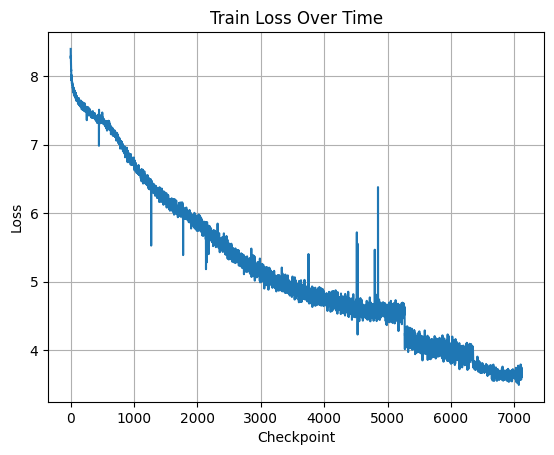

In [53]:
import matplotlib.pyplot as plt

plt.plot(train_history[10:])
plt.title("Train Loss Over Time")
plt.xlabel("Checkpoint")
plt.ylabel("Loss")
plt.grid()
plt.show()

looks yesser da5el ba3dho sooo lets smooth it 

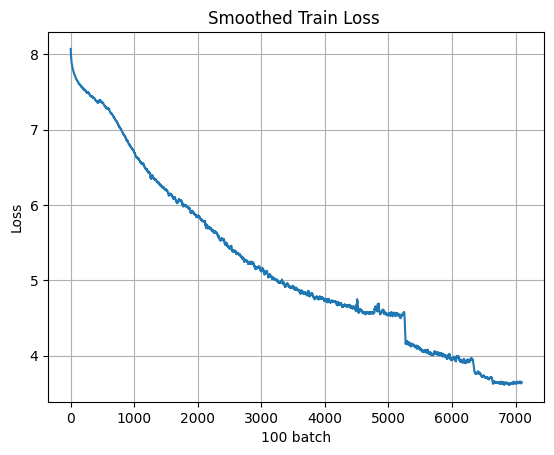

In [56]:
def smooth(data, window_size=15):
    return [sum(data[i:i+window_size])/window_size for i in range(len(data)-window_size)]
smoothed = smooth(train_history[10:], window_size=20)
plt.plot(smoothed)
plt.title("Smoothed Train Loss ")
plt.xlabel("100 batch")
plt.ylabel("Loss")
plt.grid()
plt.show()


looks great !
lets test it !

In [59]:
def predict_masked_tokens(model,masked_encodings ,batchof_mask_indexes ):
    predictions = model(masked_encodings).argmax(dim=-1)
   
    result = []

    for original_encodings ,mask_indexes , pred in zip(masked_encodings,batchof_mask_indexes , predictions):
        encodings = pred.tolist()
        original_encodings = original_encodings.tolist()
        for j in mask_indexes:
            original_encodings[j] = encodings[j]
        result.append(decode(original_encodings))
    return result


In [92]:
phrase = "waaa bro wenek nestennew fyk men bekry "
tokens , encodings = tokenize_batch([phrase] , new_vocab)
masked_tokens , masked_encodings,mask_indexes = mask_batch(tokens , encodings, vocab_dict)
input = to_tensor(masked_encodings ,new_vocab ,window_size)
prediction = predict_masked_tokens(darja_model ,input , mask_indexes)
print(f"original phrase : {phrase}")
print(f"masked phrase   : {"".join(masked_tokens[0])}")
print(f"prediction      : {prediction[0]}")



original phrase : waaa bro wenek nestennew fyk men bekry 
masked phrase   : wacbro wenek nestennew fy[MASK]men bekryص
prediction      : waa bro wenek nestennew fys men bekry[UNK]


In [95]:
phrase = "من احلى ما سمعت و ما بش نسمع في حياتي"
tokens , encodings = tokenize_batch([phrase] , new_vocab)
masked_tokens , masked_encodings,mask_indexes = mask_batch(tokens , encodings, vocab_dict)
input = to_tensor(masked_encodings ,new_vocab ,window_size)
prediction = predict_masked_tokens(darja_model ,input , mask_indexes)
print(f"original phrase : {phrase}")
print(f"masked phrase   : {"".join(masked_tokens[0])}")
print(f"prediction      : {prediction[0]}")




original phrase : من احلى ما سمعت و ما بش نسمع في حياتي
masked phrase   : [MASK]حلى[MASK]سمعت و ما بش نسمع في حياتي
prediction      : والله حلى شنو سمعت و ما بش نسمع في حياتي


# Conclusion  
the model has learned alot , it can understand the sementics behind our darija  and can understand relationships between tokens in our phrases , still not so good enaugh at predicting the missing tokens but  considering its **limited size (10 times smaller than bert base)** its expected , i believe i could have reached a better loss if i spent a bit more time collecting a higher quality data , but either way , our darja is unpredictable and unstable , each word could be written in multiple different ways , it would take a huggg amount of data + a bigger model to work better on this .
either way its now ready for finetuning onto other task


# finetuning
in this section we will take the pretrained model , finetune it for other task , for exemple

## darja sentiment analysis

first lets get the data , to do so we will create a custom dataset class (little overboard but seemed fun to try)

In [193]:
from torch.utils.data import Dataset , DataLoader
import pandas as pd
class sentiment_dataset(Dataset):
    def __init__(self ,  csv_path, transform =None):
        super().__init__()
        self.data = pd.read_csv(csv_path ,usecols=["text" ,"label"])

        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        text = self.data.iloc[idx]["text"]
        label =  self.data.iloc[idx]["label"] if self.data.iloc[idx]["label"]!=-1 else 2
        return self.transform(text) , label


we could apply a transformation function here

In [194]:
def clean_sa_text(text):
    text = re.sub(r'[^\u0600-\u06FFa-zA-Z0-9\s]', '', text)
    text = text.lower()
    text = ' '.join(text.split())

    return text

In [195]:
from sklearn.model_selection import train_test_split
sa_data = sentiment_dataset("SA_data.csv",clean_sa_text)
sa_train_data , sa_test_data  = train_test_split(sa_data , test_size=0.1)

In [196]:
print(len(sa_train_data))
print(len(sa_test_data))

63000
7000


greatt , lets create the model now , it will work as the following , we will add a CLS token at the begining of each sentence , and we will train the model to encode the class of the sentence in that token , so we can use it to classify the sentence

In [197]:
class Darja_sa(nn.Module):
    def __init__(self , base_model : nn.Module , embad_dim) -> None:
        super().__init__()
        self.model = nn.Sequential(*list(base_model.children())[:-1]) #pretrained model outputs b t d

        #usually we use this line to freeze the pretrained model , but since we didnt use cls in our original model we need to finetune it all to adjust the embading of cls token (very rookie mistake)
        """for param in self.model.parameters():
            param.requires_grad = False"""
        self.classifier = nn.Sequential(nn.Linear(embad_dim , embad_dim//2),
                                        nn.ReLU(),
                                        nn.Linear(embad_dim//2 ,3)
                                        )
    def forward(self, x):
        res = self.model(x)
        return self.classifier(res[:,0,:])


In [234]:
vocab_size = len(new_vocab)
embad_dim=256
window_size = 512
darja_model = DarjaBERT(vocab_size,embad_dim,window_size).to(device)
darja_model.load_state_dict(torch.load("darja_model.pt"))
sa_model = Darja_sa(darja_model,embad_dim).to(device)
lossf = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(sa_model.parameters() , lr=1e-5 , weight_decay=0.01)

now onto training , the principle is the following , we are going to add the cls token at the begining of each phrase 

In [227]:
def tokenize_batch(chunk , vocab_dict ,trunc = float("inf"), ignore_unk = False ):
    tokens = []
    encodings = []
    for text in chunk:
        token , encoding = tokenize(text , vocab_dict=vocab_dict, ignore_unknown = ignore_unk)
        token.insert(0,"[CLS]")
        encoding.insert(0,vocab_dict["[CLS]"])
        if len(encoding)> trunc:
            encoding = encoding[:trunc]
            token = token[:trunc]
        tokens.append(token)
        encodings.append(encoding)
    return tokens, encodings

In [241]:
epochs = 10
batch_size = 32
sa_train_dataloader = DataLoader(sa_train_data,batch_size=batch_size,shuffle = True)
sa_test_dataloader = DataLoader(sa_test_data,batch_size=batch_size,shuffle = True)


try:
    print("loading old data ")
    checkpoint = torch.load("training_state_sa.pt")
    print("check point found")
    train_history = checkpoint['train_history']
    test_history = checkpoint['test_history']
    start = checkpoint['start']
    resume_epoch = checkpoint['epoch']
    sa_model.load_state_dict(torch.load("darja_model_sa.pt"))
    print(resume_epoch)
    print(start)

except:
    print("starting new ")
    train_history = []
    test_history = []
    start = 0
    resume_epoch = 0

for epoch in range(resume_epoch, epochs):
    print("training...")
    loss_table=[]
    for iter ,batch in tqdm.tqdm(enumerate(sa_train_dataloader)):  
        if iter<start:
            continue
        texts , labels = batch
        #n7adhro el batch
        tokens , encodings = tokenize_batch(texts ,new_vocab ,trunc = window_size)
        labels=labels.to(device)
        train_batch = to_tensor(encodings ,  new_vocab ,window_size).to(device)

        # nebdaw el train

        sa_model.train()

        y_pred = sa_model(train_batch)
        loss = lossf(y_pred, labels)
        loss_table.append(loss.item())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if iter!=0 and iter % 100 ==0:
            loss_avrg = sum(loss_table) / len(loss_table)
            train_history.append(loss_avrg)
            print(f"train loss : {loss_avrg} ")
            loss_table.clear()
        #added this part cause it takes a looonnng long time and  i kept losing all my progress
        if iter!=0 and iter% 100==0:
            #nsavio el progress every 1000 steps
            torch.save({
                'train_history': train_history,
                'test_history': test_history,
                'start':  iter ,
                'epoch': epoch
            }, "training_state_sa.pt")
            torch.save(sa_model.state_dict(), "darja_model_sa.pt")
    if loss_table:
        loss_avrg = sum(loss_table) / len(loss_table)
        train_history.append(loss_avrg)
        print(f"train loss : {loss_avrg} ")
        loss_table.clear()
    print("testing...")
    test_loss_table = []

    sa_model.eval()
    with torch.inference_mode() :
        for test_iter ,batch in tqdm.tqdm(enumerate(sa_test_dataloader)):  
            
            texts , labels = batch
            #n7adhro el batch
            tokens , encodings = tokenize_batch(texts ,new_vocab ,trunc = window_size)
            labels=labels.to(device)
            test_batch = to_tensor(encodings ,  new_vocab ,window_size).to(device)


            y_pred = sa_model(test_batch)
            loss = lossf(y_pred, labels)


            test_loss_table.append(loss.item())


            if  test_iter!=0 and test_iter % 100 == 0:
                test_avg = sum(test_loss_table) / len(test_loss_table)
                test_history.append(test_avg)
                print(f"test loss : {test_avg}")
                test_loss_table.clear()
        if test_loss_table:
            test_avg = sum(test_loss_table) / len(test_loss_table)
            test_history.append(test_avg)
            print(f"test loss : {test_avg}")
            test_loss_table.clear()


    


    start = 0

loading old data 
check point found
6
1900
training...


1661it [00:00, 16455.90it/s]

train loss : 0.243794783949852 


1969it [00:14, 137.28it/s]  


train loss : 0.30402449978625073 
testing...


103it [00:11, 11.71it/s]

test loss : 0.5868487616281698


203it [00:21, 11.59it/s]

test loss : 0.5875232611596585


219it [00:23,  9.34it/s]


test loss : 0.5779734767145581
training...


101it [00:22,  2.90it/s]

train loss : 0.3153160941777843 


201it [00:44,  4.84it/s]

train loss : 0.33202811107039454 


301it [01:06,  4.54it/s]

train loss : 0.34136503145098684 


401it [01:29,  3.94it/s]

train loss : 0.3161483037471771 


501it [01:51,  4.07it/s]

train loss : 0.3310712774097919 


601it [02:12,  4.94it/s]

train loss : 0.3399214096367359 


701it [02:32,  5.71it/s]

train loss : 0.3408610686659813 


801it [02:54,  4.34it/s]

train loss : 0.34104094743728636 


901it [03:16,  3.93it/s]

train loss : 0.34872049853205683 


1001it [03:37,  3.88it/s]

train loss : 0.32087556131184103 


1101it [03:57,  4.84it/s]

train loss : 0.331924661397934 


1201it [04:20,  3.90it/s]

train loss : 0.34544093802571296 


1301it [04:42,  4.87it/s]

train loss : 0.32330946177244185 


1401it [05:05,  4.51it/s]

train loss : 0.34064950242638586 


1500it [05:28,  5.16it/s]

train loss : 0.33980477079749105 


1600it [05:50,  3.74it/s]

train loss : 0.34503229409456254 


1700it [06:11,  5.81it/s]

train loss : 0.33337887227535246 


1801it [06:32,  5.12it/s]

train loss : 0.30598163202404977 


1901it [06:55,  4.70it/s]

train loss : 0.33860808953642846 


1969it [07:08,  4.59it/s]


train loss : 0.3162865338518339 
testing...


102it [00:12, 10.32it/s]

test loss : 0.616584067297454


202it [00:22, 12.76it/s]

test loss : 0.6128488346934319


219it [00:24,  8.89it/s]


test loss : 0.5917740927802192
training...


83it [00:22,  3.70it/s]


KeyboardInterrupt: 

the test accuracy is not improving anymore, so lets stop it there

In [239]:
def evaluate_accuracy(model, dataloader, vocab, window_size):
    model.eval()
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch in tqdm.tqdm(dataloader):
            texts, labels = batch
            tokens, encodings = tokenize_batch(texts, vocab, trunc=window_size)
            inputs = to_tensor(encodings, vocab, window_size).to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [242]:
print("🔍 Evaluating final accuracy...")

train_acc = evaluate_accuracy(sa_model, sa_train_dataloader, new_vocab, window_size)
test_acc = evaluate_accuracy(sa_model, sa_test_dataloader, new_vocab, window_size)

print(f"✅ Final Train Accuracy: {train_acc * 100:.2f}%")
print(f"✅ Final Test Accuracy: {test_acc * 100:.2f}%")


🔍 Evaluating final accuracy...


100%|██████████| 219/219 [00:23<00:00,  9.49it/s]

✅ Final Train Accuracy: 89.62%
✅ Final Test Accuracy: 75.86%


yeah not so bad considering my setup , hopefully on my next tries , with a bit of planning , better data and better hardware , this could be a better model



thank you for following along , if you didnt understand anything , feel free to contact me : https://www.linkedin.com/in/mahdi-ben-ameur-5089ba240/